In [1]:
import geopandas
from matplotlib import colors
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import geohash
import numpy as np
import cartopy.crs as ccrs
import pandas as pd

## Parse / Scraping map data

In [111]:
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup

In [119]:
df_dict = {
    "names": [],
    "lat": [],
    "long": [],
    "altitudes_m": [],
    "minelevations_deg": []
}

table_query_str = "https://network.satnogs.org/stations/?testing=0&offline=0&future=0&freq=&page={}"
station_query_str = "https://network.satnogs.org{}"

for i in range(14):
    idx = i+1
    print("Parse page:", idx)
    
    resp = requests.get(query_str.format(idx))
    soup = BeautifulSoup(resp.text)
    gstable = soup.find("table")
    rows = gstable.find_all("tr")
    
    for row in tqdm(rows):
        resp = requests.get(station_query_str.format(row["data-href"]))
        soup = BeautifulSoup(resp.text)

        # Name
        name = soup.find("h2").text.strip()
        df_dict["names"].append(name)

        rowarray = soup.find("tbody").find_all("tr")

        # Coordinates
        coords_str = rowarray[2].find_all("td")[1].text.strip()
        lat_str, lon_str = coords_str.split(",")
        lat = float(lat_str[:-1])
        lon = float(lon_str[:-1])
        df_dict["lat"].append(lat)
        df_dict["long"].append(lon)

        # Altitude in meter
        altitude_m = rowarray[3].find_all("td")[1].text.strip().split(" ")[0]
        df_dict["altitudes_m"].append(altitude_m)

        # Min Elevation in deg
        minelevation_deg = rowarray[4].find_all("td")[1].text.strip().split("°")[0]
        df_dict["minelevations_deg"].append(minelevation_deg)

df = pd.DataFrame(df_dict)
df

Parse page: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.86it/s]


Parse page: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.50it/s]


Parse page: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.49it/s]


Parse page: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.22it/s]


Parse page: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56it/s]


Parse page: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.41it/s]


Parse page: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.41it/s]


Parse page: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


Parse page: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.36it/s]


Parse page: 10


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Parse page: 11


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Parse page: 12


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Parse page: 13


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.12it/s]


Parse page: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.07it/s]


,names,lat,long,altitudes_m,minelevations_deg
0,2 - KB9JHU,39.236,-86.305,280,5
1,6 - Apomahon,38.048,23.739,119,20
2,9 - Talos,35.501,24.011,82,15
3,12 - W2BFJ,42.744,-71.538,67,4
4,21 - Avia,36.961,22.145,45,45
...,...,...,...,...,...
262,3022 - propulsion.industries,20.725,-103.423,1595,10
263,3024 - Drachten S-band,53.109,6.108,6,10
264,3027 - WH6GVF VHF,19.415,-154.892,15,5
265,3035 - DO7OO WHQ,53.046,8.891,9,5


In [120]:
df.to_csv("data/gsdata/gsdata_satnog.csv")

## Plotting GSaaS Map

In [121]:
# https://network.satnogs.org/stations/
# Scraped, see code above
gsdata_satnog = pd.read_csv("data/gsdata/gsdata_satnog.csv")

# https://www.ksat.no/ground-network-services/the-ksat-global-ground-station-network/
# Accessed: 2023-03-08
gsdata_ksat   = pd.read_csv("data/gsdata/gsdata_ksat.csv")

# https://atlasground.com/wp-content/uploads/2022/12/WEB-120522-Antenna-Network-Map.pdf
# Accessed: 2023-03-09
gsdata_atlas  = pd.read_csv("data/gsdata/gsdata_atlas.csv")

# https://leaf.space/
# Accessed: 2023-03-09
gsdata_leaf   = pd.read_csv("data/gsdata/gsdata_leaf.csv")

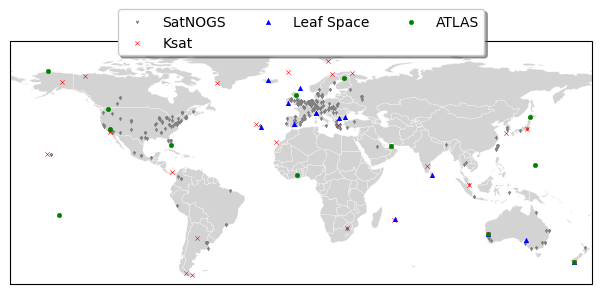

In [134]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world[(world.name!="Antarctica")]

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2, linewidth=0.0 ))


fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "lightgrey", edgecolor="white", ax=ax, linewidth=0.2)

# Plotting GS points
def plot_gsdata(gsdata_df, ax, label, marker, color, size=10):
    latitude, longitude = gsdata_df["lat"], gsdata_df["long"]
    ax.scatter(longitude, latitude,
               sizes = [size],
               color=color,
               zorder = 10,
               marker=marker,
               linewidth = 0.4,
               label=label)

plot_gsdata(gsdata_satnog, ax, "SatNOGS", "v", "grey", 4)
plot_gsdata(gsdata_ksat, ax, "Ksat", "x", "red")
plot_gsdata(gsdata_leaf, ax, "Leaf Space", "^", "blue")
plot_gsdata(gsdata_atlas, ax, "ATLAS", "o", "green")

    
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#plt.legend(loc = "lower left")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16),
          ncol=3, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("figures/gs_services.pdf", pad_inches=0)
plt.show()